# Project 1 Boundary feature detection
* Extract the edge of the provided tumor mask

•Morphological processing
•Gradient operator: ‘Sobel’, ‘Robert’, ’Prewitt’ et al. 
* Perform Boundary tracing method (8-neighbours)
* Represent the boundary using Freeman chain code

•Subsample
•First difference
•Integer of minimum magnitude
•Coordinates of the Start point

[179,197]
起点坐标为:[179,197]
Freeman code子样本:[0 1 1 0 1 1 0 1 1 0 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 1 0 0
 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 7 6 6 7 6
 6 6 7 6 7 6 6 6 6 6 6 6 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 7 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 6 6 6 6 6 6 6 6 6
 6 5 6 6 6 6 6 6 5 6 6 6 6 6 6 5 6 6 6 6 5 6 5 5 6 5 6 5 5 5 5 4 5 5 4 5 5
 5 5 5 5 5 4 5 5 4 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4 3 3 4 3 4
 3 4 4 3 4 4 3 4 4 3 4 4 3 2 3 3 3 3 2 3 3 2 2 2 3 2 2 2 3 2 2 2 3 2 2 3 2
 2 3 4 3 4 4 4 4 4 3 4 4 4 4 4 3 3 3 3 3 3 3 4 3 2 2 2 2 3 2 2 2 2 2 2 2 2
 2 2 2 1 2 2 2 1 2 2 2 1 2 1 1 2 1 2 1 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1]
链码归一化:[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 7 6 6 7 6 6 6
 7 6 7 6 6 6 6 6 6 6 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 7 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 6 6 6 6 6 6 6 6 6 6 5
 6 6 6 6 6 6 5 6 6 6 6 6 6 5 6 6 6 6 5 6 5

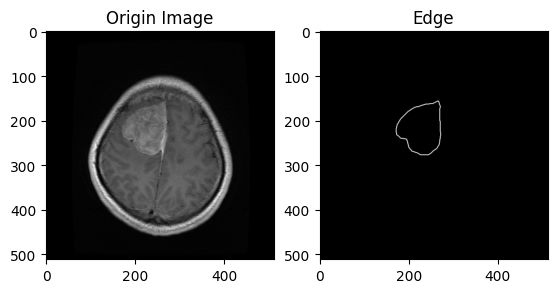

In [49]:
import cv2 as cv
import os
import math
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))

data = np.load('tumor.npy')
tumor_Mask = data['tumorMask'][0,:,:]
tumor_Border = data['tumorBorder'][0,:,:]

data = data['image'][0,:,:]

Mask = np.zeros_like(data)
Mask[tumor_Mask == False] = 0
Mask[tumor_Mask == True] = 1
P = data.shape[0]
Q = data.shape[1]

plt.subplot(2,3,1)
plt.title("Origin Image")
plt.imshow(data,cmap='gray')

# 形态学处理
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3))
tumor_Mask = cv.erode(Mask, kernel=kernel)
tumor_Mask = cv.dilate(Mask, kernel=kernel)

# 梯度算子
sobel_x = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]])
sobel_y = np.array([[-1, -2, -1],
                    [0, 0, 0],
                    [1, 2, 1]])
grad_x = cv.filter2D(tumor_Mask, -1, sobel_x)
grad_y = cv.filter2D(tumor_Mask, -1, sobel_y)
grad = np.sqrt(grad_x**2 + grad_y**2)

plt.subplot(2,3,2)
plt.title("Edge")
plt.imshow(grad,cmap='gray')

# 边界跟踪
def Boundary_tracing(Img):

    Width = np.shape(Img)[0]
    Height = np.shape(Img)[1]
    tracing = np.zeros_like(Img)
    Freeman_code = np.zeros(0,int)

    # 寻找左上的边界点
    tracing[Img > 0] = 1
    min_i = Width - 1
    min_j = Height - 1
    for i in range(Width):
        for j in range(Height):
            if(tracing[i][j] > 0 and (min_i + min_j) > (i+j)):
                min_i = i
                min_j = j

    # 开始边界跟踪
    start_i = min_i
    start_j = min_j
    print("["+str(min_i)+","+str(min_j)+"]")
    c_i = start_i
    c_j = start_j - 1
    while True:
        freeman = -1
        # 顺时针寻找下一个点
        while tracing[c_i][c_j] == 0:
            pre_i = c_i
            pre_j = c_j
            #print("["+str(c_i)+","+str(c_j)+"]")
            if start_j - c_j == 1 and start_i == c_i:
                c_i = c_i - 1   #c在b左
            elif start_j - c_j == 1 and start_i - c_i == 1:
                c_j = c_j + 1   #c在b左上
            elif start_j - c_j == 1 and start_i - c_i == -1:
                c_i = c_i - 1   #c在b左下

            elif start_j == c_j and start_i - c_i == 1:
                c_j = c_j + 1   #c在b上
            elif start_j == c_j and start_i - c_i == -1:
                c_j = c_j - 1   #c在b下

            elif start_j - c_j == -1 and start_i - c_i == 1:
                c_i = c_i + 1   #c在b右上
            elif start_j - c_j == -1 and start_i == c_i:
                c_i = c_i + 1   #c在b右
            elif start_j - c_j == -1 and start_i - c_i == -1:
                c_j = c_j - 1   #c在b右下

        # 计算Freeman code
        if start_i - c_i == 1 and start_j == c_j:
                freeman = 2 #正上
        elif start_i - c_i == 1 and start_j - c_j == 1:
                freeman = 3 #左上
        elif start_i - c_i == 1 and start_j - c_j == -1:
                freeman = 1 #右上
        elif start_i == c_i and start_j - c_j == 1:
                freeman = 4 #正左
        elif start_i == c_i and start_j - c_j == -1:
                freeman = 0 #正右
        elif start_i - c_i == -1 and start_j - c_j == 1:
                freeman = 5 #左下
        elif start_i - c_i == -1 and start_j - c_j == 0:
                freeman = 6 #正下
        elif start_i - c_i == -1 and start_j - c_j == -1:
                freeman = 7 #右下
        start_i = c_i
        start_j = c_j
        Freeman_code = np.append(Freeman_code,freeman)
        c_i = pre_i
        c_j = pre_j

        if start_i == min_i and start_j == min_j:
            break

    return tracing, Freeman_code, min_i, min_j

tracing_1, Freeman_code_1, start_i, start_j = Boundary_tracing(grad)
# 起点坐标
print("起点坐标为:["+str(start_i)+","+str(start_j)+"]")
# Freeman code子样本
print("Freeman code子样本:"+str(Freeman_code_1))
# 链码归一化
t1 = Freeman_code_1[0:39]
guiyi_code = np.append(Freeman_code_1[39:Freeman_code_1.size-1], t1)
print("链码归一化:"+str(guiyi_code))
# 差分码
difference_one = np.zeros(0,int)
for i in range(Freeman_code_1.size):
    difference_one = np.append(difference_one, 
        (Freeman_code_1[(Freeman_code_1.size + i - 1) % Freeman_code_1.size] - Freeman_code_1[i] + 8) % 8)
     
print("差分码:"+str(difference_one))




# Project 2 Texture analysis
* Use the provided data of brain tumor MRI
+ Extract the tumor region with the provided mask
+ For the tumor region, rescale the region to 128 levels, compute GLCM with a operator along x axis(1 pixel to 
the right) and along y axis (1 pixel down) respectively
+ Compute the homogeneity, correlation, and the contrast of GLCM.
+ Conduct analysis above once again for the normal part from the other hemisphere
+ Compare your result with functions in MATLAB and tell the difference 

## 计算肿瘤部分的GLCM以及相关系数

同质性homogeneity:0.48092786193483544
75.12984802431609,75.45568389057748
99.93256198298239,101.37387194870706
相关性correlation:0.009559915920918136
对比度contrast:7.718176291793321


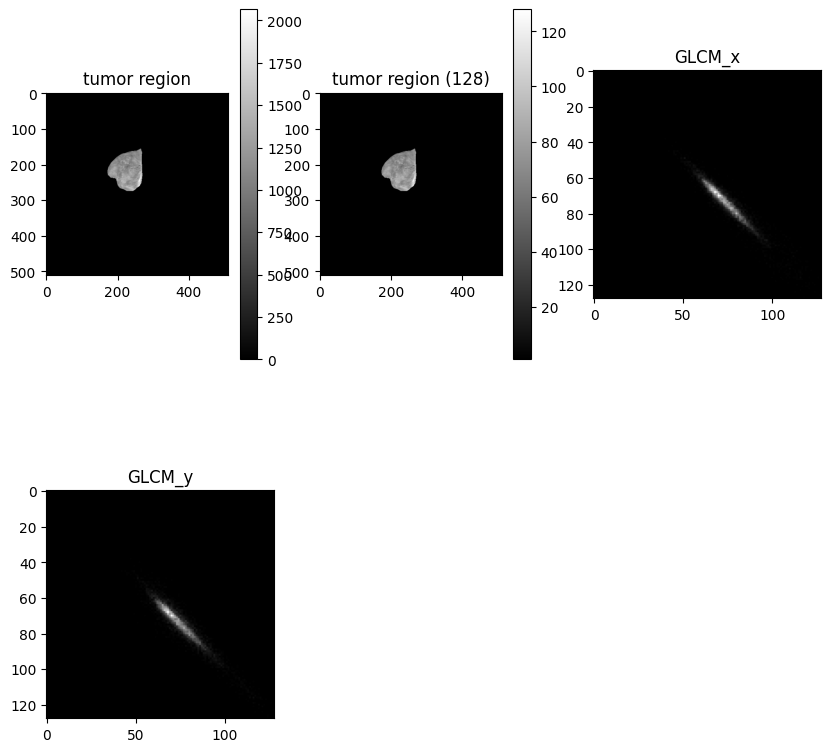

In [50]:
import cv2 as cv
import os
import math
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))

data = np.load('tumor.npy')
tumor_Mask = data['tumorMask'][0,:,:]
tumor_Border = data['tumorBorder'][0,:,:]

data = data['image'][0,:,:]

Mask = np.zeros_like(data)
Mask[tumor_Mask == False] = 0
Mask[tumor_Mask == True] = 1
P = data.shape[0]
Q = data.shape[1]

tumor = np.copy(data)
tumor[Mask == 0] = 0

plt.subplot(2,3,1)
plt.title("tumor region")
plt.imshow(tumor,cmap='gray')
plt.colorbar()

# 灰度调整至128级
interval = tumor.max() / 127
for i in range(P):
    for j in range(Q):
        tumor[i][j] = int(tumor[i][j] / interval) + 1

plt.subplot(2,3,2)
plt.title("tumor region (128)")
plt.imshow(tumor,cmap='gray')
plt.colorbar()

# GLCM
def Create_GLCM_x(data):
    height, width = data.shape[:2]
    GLCM = np.zeros((128,128),int)
    for i in range(height):
        for j in range(width - 1):
            if tumor[i][j] != 1 and tumor[i][j+1] != 1: #保证在tuomr region内
                GLCM[data[i][j] - 1][data[i][j+1] - 1] = GLCM[data[i][j] - 1][data[i][j+1] - 1]  + 1
    return GLCM

def Create_GLCM_y(data):
    height, width = data.shape[:2]
    GLCM = np.zeros((128,128),int)
    for j in range(width):
        for i in range(height - 1):
            if tumor[i][j] != 1 and tumor[i+1][j] != 1:
                GLCM[data[i][j] - 1][data[i+1][j] - 1] = GLCM[data[i][j] - 1][data[i+1][j] - 1]  + 1
    return GLCM

GLCM_1 = Create_GLCM_x(tumor)
plt.subplot(2,3,3)
plt.title("GLCM_x")
plt.imshow(GLCM_1,cmap='gray')

GLCM_2 = Create_GLCM_y(tumor)
plt.subplot(2,3,4)
plt.title("GLCM_y")
plt.imshow(GLCM_2,cmap='gray')

#-----------------------
# GLCM的同质性、相关性和对比度
#-----------------------

# 概率p
p = GLCM_1 / np.sum(GLCM_1)

#-----------------------
# 同质性
#-----------------------
homogeneity = 0
for i in range(128):
    for j in range(128):
        homogeneity = homogeneity + p[i][j] / (1+np.abs(i-j))
print("同质性homogeneity:"+str(homogeneity))

#-----------------------
# 相关性
#-----------------------
correlation = 0
# 均值 行、列
m_r = 0
for i in range(128):
    x = 0
    for j in range(128):
        x = x + p[i][j]
    m_r = m_r + (i+1) * x
m_c = 0
for j in range(128):
    x = 0
    for i in range(128):
        x = x + p[i][j]
    m_c = m_c + (j+1) * x

# 标准差 行、列
std_r = 0
for i in range(128):
    x = 0
    for j in range(128):
        x = x + p[i][j]
    std_r = std_r + (i+1-m_r)**2 * x
        
std_c = 0
for j in range(128):
    x = 0
    for i in range(128):
        x = x + p[i][j]
    std_c = std_c + (j+1-m_c)**2 * x

for i in range(128):
    for j in range(128):
        correlation = correlation + ((i + 1 - m_r) * (j + 1 - m_c) * p[i][j]) / (std_c * std_r)

print(str(m_r) + "," + str(m_c))
print(str(std_r) + "," + str(std_c))
print("相关性correlation:" + str(correlation))

#-----------------------
# 对比度
#-----------------------
contrast = 0
for i in range(128):
    for j in range(128):
        contrast = contrast + p[i][j]*(i - j)**2 

print("对比度contrast:" + str(contrast))



## 接下来计算正常部分的GLCM

同质性homogeneity:0.6927837622495244
22.048311876902453,22.03799603451646
592.3409204516448,591.6860482726534
相关性correlation:0.0016773743808478998
对比度contrast:8.255203998994702


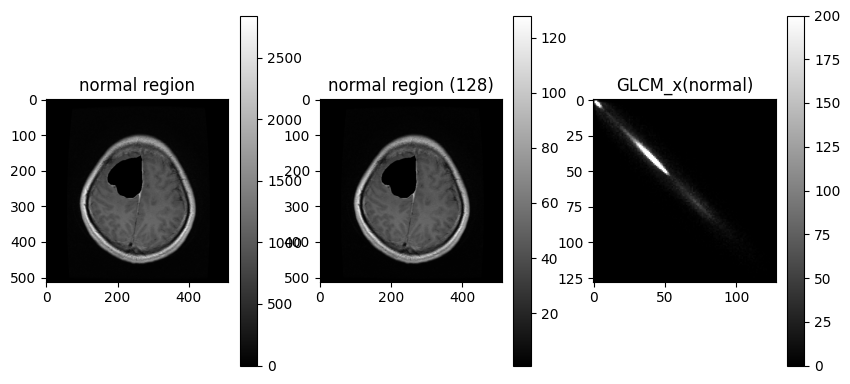

In [59]:
# ------------------------
# 接下来计算正常部分的GLCM
# ------------------------
plt.figure(figsize=(10, 10))

normal = np.copy(data)
normal[Mask == 1] = 0

plt.subplot(2,3,1)
plt.title("normal region")
plt.imshow(normal,cmap='gray')
plt.colorbar()

# 灰度调整至128级
interval = normal.max() / 127
for i in range(P):
    for j in range(Q):
        normal[i][j] = int(normal[i][j] / interval) + 1

plt.subplot(2,3,2)
plt.title("normal region (128)")
plt.imshow(normal,cmap='gray')
plt.colorbar()

def Create_GLCM_normal(data):
    height, width = data.shape[:2]
    GLCM = np.zeros((128,128),int)
    for i in range(height):
        for j in range(width - 1):
            if Mask[i][j] == 0 and Mask[i][j+1] == 0 and data[i][j] != 1 and data[i][j+1] != 1: #保证在tuomr region外
                GLCM[data[i][j] - 1][data[i][j+1] - 1] = GLCM[data[i][j] - 1][data[i][j+1] - 1]  + 1
    return GLCM

GLCM_3 = Create_GLCM_normal(normal)
# GLMC3中将最大值阈值调低，使得图像清晰
GLCM_3_1 = np.copy(GLCM_3)
GLCM_3_1[GLCM_3_1>200] = 200

plt.subplot(2,3,3)
plt.title("GLCM_x(normal)")
plt.imshow(GLCM_3_1,cmap='gray')
plt.colorbar()

#-----------------------
# GLCM的同质性、相关性和对比度
#-----------------------

# 概率p
p = GLCM_3 / np.sum(GLCM_3)

#-----------------------
# 同质性
#-----------------------
homogeneity = 0
for i in range(128):
    for j in range(128):
        homogeneity = homogeneity + p[i][j] / (1+np.abs(i-j))
print("同质性homogeneity:"+str(homogeneity))

#-----------------------
# 相关性
#-----------------------
correlation = 0
# 均值 行、列
m_r = 0
for i in range(128):
    x = 0
    for j in range(128):
        x = x + p[i][j]
    m_r = m_r + (i+1) * x
m_c = 0
for j in range(128):
    x = 0
    for i in range(128):
        x = x + p[i][j]
    m_c = m_c + (j+1) * x

# 标准差 行、列
std_r = 0
for i in range(128):
    x = 0
    for j in range(128):
        x = x + p[i][j]
    std_r = std_r + (i+1-m_r)**2 * x
        
std_c = 0
for j in range(128):
    x = 0
    for i in range(128):
        x = x + p[i][j]
    std_c = std_c + (j+1-m_c)**2 * x

for i in range(128):
    for j in range(128):
        correlation = correlation + ((i + 1 - m_r) * (j + 1 - m_c) * p[i][j]) / (std_c * std_r)

print(str(m_r) + "," + str(m_c))
print(str(std_r) + "," + str(std_c))
print("相关性correlation:" + str(correlation))

#-----------------------
# 对比度
#-----------------------
contrast = 0
for i in range(128):
    for j in range(128):
        contrast = contrast + p[i][j]*(i - j)**2 

print("对比度contrast:" + str(contrast))


# Disclosure
* 【OpenCV】Chapter8.形态学图像处理 https://blog.csdn.net/qq1198768105/article/details/126592056
* 【OpenCV 例程 300篇】231. 特征描述之灰度共生矩阵（GLCM） https://blog.csdn.net/youcans/article/details/125693533